In [94]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
import copy

In [2]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

In [3]:
def genStatsDF(dfOrig):
    '''
    Generates a new dataframe that merges duplicate entries, while supplying avg/std/no.

    input: DataFrame with 2 columns, first is composition, second is property
    output: Datafrme with 4 columns

    '''
    yDcopy = dfOrig.copy()
    (col1, col2) = dfOrig.columns

    redList = []
    cnt=0
    while ~yDcopy.empty and cnt < len(yDcopy):
        compTemp = yDcopy[col1][0]
        
        # difference must be below atol+rtol*mean.  
        dupes = yDcopy[ [x.almost_equals(compTemp) for x in yDcopy[col1]] ]

        tempDict = {col1: compTemp, col2+'_avg': dupes[col2].mean(), 
                    col2+'_std': dupes[col2].std(), 'numSamp': len(dupes)}

        redList.append(tempDict)

        #remove processed entries
        yDcopy.drop(index=list(dupes.index), inplace=True)
        yDcopy.reset_index(drop=True, inplace=True)
        cnt+=1

    reducedDF = pd.DataFrame(redList)
    return reducedDF

# Import and Format datasets

In [4]:
elastProp_SLAC = pd.read_excel('datasets/Mechnical properties analysis v33_Pruned.xlsx')
rawCopy = elastProp_SLAC.copy()
len(rawCopy)

2174

In [5]:
elastProp_SLAC.head()

,Compositions,Sample,Conditions,Tensile strength (MPa),Error,"Yeild strength, σy (MPa)",Error,Elongation (%),"Compressive fracture strength, σf (MPa)",Error.1,...,Vd (%),Strain hardening rate,ρ (g/cm3),"Stress Intensity, Kc",G/K,θd,"Energy of fracture,Gc",Glasses,"Diameter, mm",Reference2
0,Zr55Al10Ni5Cu30,Zr-based,NaN,1840,NaN,NaN,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"B. Guennec et al, Intermetallics 92 (2018) 72–78"
1,Zr61Ti2Cu25Al12,Zr-based,NaN,1600,NaN,NaN,NaN,NaN,1688,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"Z-Q Song et al, Acta Materialia 99 (2015) 165–175"
2,Zr56Co24Ag4Al16,Zr-based,(electric charge 100 Ag),2284,63,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
3,Zr56Co24Ag4Al16,Zr-based,(electric charge 90 Ag),2197,48,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
4,Al20Co25Zr55,Al-based,NaN,2050,NaN,NaN,NaN,2.1,2200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."


In [6]:
elastProp_SLAC.rename(index=str, columns={'θd':'theta_d', 'ρ (g/cm3)':'density (g/cm3)', 
                                          'Yeild strength, σy (MPa)':'Yeild strength (MPa)', 
                                         'Compressive fracture strength, σf (MPa)': 'Compressive fracture strength (MPa)'},inplace=True)
#elastProp_SLAC.columns

In [7]:
dfSLAC = elastProp_SLAC

In [8]:
def makeComp(x):
    '''Apply Composition() constructor to string x
       Return: Composition object, or 0 if not parse-able'''
    try:
        return Composition(x)
    except:
        print(x)
        return 0

In [9]:
# prints out compositions that cannot be converted into Composition objects
dfSLAC['comp'] = dfSLAC['Compositions'].apply(makeComp)

Mg60Ca30−xTixY10
Mg60Li5Cu25−xZnx (Y, Gd)10
Mg65−xLixCu25Znx (Y, Gd)10
(CaCu)100xMgx
La57.6Al17.5(Cu,Ni)24.9
La64Al14 (Cu = Ni)22
Fused quartz
Amorphous carbon
Microcrystal glass
Breakaway glass
Water-white glass
Window glass
Float glass
Ti-glass
Borosilicate glass
B2O3 glass
Glassy sulfur
Amorphous Se
Fused quartz
window glass (SiO2)
∥Fe70Mo5Ni5∣P12.5∥C5B2.5∣
Toughened glass (SiO2)
Amorphous carbon
Vit1
Float glass
Ti-glass
Window glass
Water-white glass
Fused quartz
Microcrystal glass
Borosilicate glass
Carbon glass
Mo52Cr14Fel4P12B8
Fused silica
Window glass
Toughened glass
Sn 99.9%
(Zr54Al17C029)100-0Ta0
316L SS
Ti-6Al-4V
Cortical bone
Vitreloy 105
FC20+0.4 wt.% B
La74Al14(Cu,Ni)12
300 M Steel
D6AC Steel 
Ti-6Al-4V 
2090-T81 Al–Li 


Remove entries where composition was unable to be read

In [10]:
dfSLAC = dfSLAC[dfSLAC['comp']!=0]
dfSLAC.reset_index(drop=True, inplace=True)
print('{} entries remaining'.format(len(dfSLAC)))

2126 entries remaining


In [11]:
cols = dfSLAC.columns.tolist()
dfSLAC = dfSLAC[cols[-1:] + cols[:-1]]
print("moved 'comp' to first column")

moved 'comp' to first column


In [12]:
len(dfSLAC['comp']!=0)

2126

In [13]:
def redComp(x):
    try: 
        return Composition(x.reduced_formula)
    except: 
        print(x)
        return 0
    
dfSLAC['comp'] = dfSLAC['comp'].apply(redComp)
dfSLAC = dfSLAC[dfSLAC['comp']!=0]
dfSLAC.reset_index(drop=True, inplace=True)
print('{} entries remaining'.format(len(dfSLAC)))

C:\Users\Hikaru\Anaconda2\envs\py36\lib\site-packages\pymatgen\core\periodic_table.py:409: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.




2125 entries remaining


In [14]:
dfSLAC.head()

,comp,Compositions,Sample,Conditions,Tensile strength (MPa),Error,Yeild strength (MPa),Error,Elongation (%),Compressive fracture strength (MPa),...,Vd (%),Strain hardening rate,density (g/cm3),"Stress Intensity, Kc",G/K,theta_d,"Energy of fracture,Gc",Glasses,"Diameter, mm",Reference2
0,"(Zr, Al, Cu, Ni)",Zr55Al10Ni5Cu30,Zr-based,NaN,1840,NaN,NaN,NaN,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"B. Guennec et al, Intermetallics 92 (2018) 72–78"
1,"(Zr, Ti, Al, Cu)",Zr61Ti2Cu25Al12,Zr-based,NaN,1600,NaN,NaN,NaN,NaN,1688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"Z-Q Song et al, Acta Materialia 99 (2015) 165–175"
2,"(Zr, Al, Co, Ag)",Zr56Co24Ag4Al16,Zr-based,(electric charge 100 Ag),2284,63,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
3,"(Zr, Al, Co, Ag)",Zr56Co24Ag4Al16,Zr-based,(electric charge 90 Ag),2197,48,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."
4,"(Zr, Al, Co)",Al20Co25Zr55,Al-based,NaN,2050,NaN,NaN,NaN,2.1,2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMG,NaN,"M. Mohammadi Rahvard et al, Journal of Non-Cry..."


Import NREL dataset

In [15]:
NRELmodulusDataPath= 'C:\\Users\\Hikaru\\Desktop\\School\\_Stanford\\_SLAC\\MechPropModels\\ryan\'s code\\MG_elastic_properties_package\\datasets\\SLAC_Modulus_Only_Cleaned_modified_trim.xlsx'
elastProp_NREL = pd.read_excel(NRELmodulusDataPath)
rawCopy = elastProp_NREL.copy()
rawCopy.head()

,Compositions,Youngs_Modulus_GPa,Shear_Modulus_GPa,Bulk_Modulus_GPa,density
0,Se70Ge30,15.7,6.2,11.7,4.277
1,Zn20Ca20Sr20Yb20Li11Mg9,16.0,6.3,12,3.6
2,Zn20Ca20Sr20Yb20Li11Mg9,16.0,6.3,None,None
3,Sr60Li5Mg15Zn20,18.4,7.02,16.1,2.99
4,Mg81Cu9.3Y4.7Zn5,19.2,None,None,2.47


In [16]:
elastProp_NREL['comp'] = elastProp_NREL['Compositions'].apply(makeComp)
elastProp_NREL['comp'] = elastProp_NREL['comp'].apply(redComp)

C:\Users\Hikaru\Anaconda2\envs\py36\lib\site-packages\pymatgen\core\periodic_table.py:409: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.



In [17]:
elastProp_NREL['comp'][0]
# Compositions have been standardized and reduced

Comp: Ge3 Se7

In [18]:
# cell about Composition.almost_equal() method experimentation was here
# Note that an unreduced chemical formula is not equal in composition

# Build individual datasets

### Generate, clean feature set

In [107]:
base_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

### Young's Modulus dataset 
Isolate Youngs Modulus, Composition.
Build Features

In [20]:
# Separate Data into new frame
youngsSLAC = pd.DataFrame()
youngsSLAC['comp'] = dfSLAC['comp']
youngsSLAC['E'] = dfSLAC['Young’s  Modulus, E (GPa)']

# Drop missing entries 
youngsSLAC = youngsSLAC[[(type(x) in (int, float)) for x in youngsSLAC['E']]]
youngsSLAC.reset_index(drop=True, inplace=True)
youngsSLAC = youngsSLAC[~youngsSLAC['E'].isnull()]
youngsSLAC['E'].astype(float)
youngsSLAC.reset_index(drop=True, inplace=True)

# Separate Data into new frame
youngsNREL = pd.DataFrame()
youngsNREL['comp'] = elastProp_NREL['comp']
youngsNREL['E'] = elastProp_NREL['Youngs_Modulus_GPa']

# Drop missing entries
youngsNREL = youngsNREL[[(type(x) in (int, float)) for x in youngsNREL['E']]]
youngsNREL.reset_index(drop=True, inplace=True)
youngsNREL = youngsNREL[~youngsNREL['E'].isnull()]
youngsNREL['E'].astype(float)
youngsNREL.reset_index(drop=True, inplace=True)

In [21]:
# Join and sort data (SLAC dataset is complete)
youngsData = youngsSLAC #.append(youngsNREL, ignore_index=True)
youngsData = youngsData.sort_values('comp').reset_index(drop=True)
print('{} = {} + {}?'.format(len(youngsData), len(youngsSLAC), len([])))

C:\Users\Hikaru\Anaconda2\envs\py36\lib\site-packages\pymatgen\core\periodic_table.py:409: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.



1203 = 1203 + 0?


In [22]:
%%time
X_E = base_featurizer.featurize_many(youngsData['comp'], ignore_errors=True)
X_E = np.array(X_E)
X_E.astype(float)
print('Computed {} features'.format(X_E.shape[1]))

Computed 152 features
Wall time: 18min 10s


In [23]:
# Create smaller dataset for quick tests
youngsDataSmall = youngsData.sample(500).reset_index(drop=True)

In [24]:
XEsmall = base_featurizer.featurize_many(youngsDataSmall['comp'], ignore_errors=True)
XEsmall = np.array(XEsmall)
XEsmall.astype(float)
print('Computed {} features'.format(XEsmall.shape[1]))

KeyboardInterrupt: 

In [ ]:
# some duplicates exist
comp = Composition('Zr14Al4Co7')
comp2 = Composition('Zr20Al4Co7') 
for index, row in youngsData[ [x.almost_equals(comp) for x in youngsData['comp']] ].iterrows():
    print('Comp: {} .... at row: {}'.format(row['comp'], index))

In [25]:
print(np.where(np.isnan(X_E)))
featCleanImpute(X_E)
print(np.where(np.isnan(X_E)))

(array([   0,    0,    0, ..., 1202, 1202, 1202], dtype=int64), array([  0,   1,   2, ..., 149, 150, 151], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [26]:
with gzip.open('./datasets/youngs_features.pkl.gz', 'wb') as fp:
    pkl.dump(X_E, fp)
with gzip.open('./datasets/youngs_data.pkl.gz', 'wb') as fd:
    pkl.dump(youngsData, fd)

In [27]:
with gzip.open('./datasets/youngsSmall_features.pkl.gz', 'wb') as fp:
    pkl.dump(XEsmall, fp)
with gzip.open('./datasets/youngsSmall_data.pkl.gz', 'wb') as fd:
    pkl.dump(youngsDataSmall, fd)

NameError: name 'XEsmall' is not defined

#### Generate new dataframe, reducing duplicates

In [28]:
%%time
youngsReduced = genStatsDF(youngsData)
youngsReduced.head()

Wall time: 5.21 s


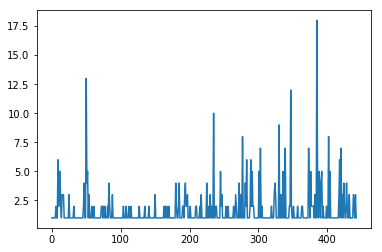

In [29]:
youngsReduced['numSamp'].plot()

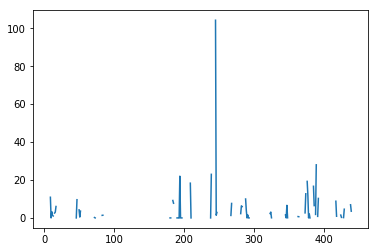

In [30]:
youngsReduced['E_std'].plot()

In [31]:
eleDict = comp.as_dict()
print(eleDict)
print(eleDict.popitem())
print(eleDict)

NameError: name 'comp' is not defined

In [ ]:
dfSLAC.columns

### Density Model Dataset
Use as benchmark for validity of other models?

In [60]:
densitySLAC = pd.DataFrame()
densitySLAC['comp'] = dfSLAC['comp']
densitySLAC['density'] = dfSLAC['density (g/cm3)']

densitySLAC.dropna(inplace=True)
densitySLAC.reset_index(drop=True, inplace=True)
densitySLAC = densitySLAC[[(type(x) in (int, float)) for x in densitySLAC['density']]]
densitySLAC['density'].astype(float)
densitySLAC.reset_index(drop=True, inplace=True)

In [61]:
print('dropping N/A, non number density values leaves {} values'.format(len(densitySLAC)))
densitySLAC.head()

dropping N/A, non number density values leaves 746 values


,comp,density
0,"(Ce, Al)",3.462
1,"(Al, Fe, B)",3.539
2,"(Zr, Al, Ni)",3.384
3,"(Zr, Al, Ni)",3.517
4,"(Hf, Al, Ni)",2.835


In [62]:
densityNREL = pd.DataFrame()
densityNREL['comp'] = elastProp_NREL['comp']
densityNREL['density'] = elastProp_NREL['density']

In [63]:
densityNREL.dropna(inplace=True)
densityNREL.reset_index(inplace=True)
densityNREL = densityNREL[[(type(x) in (int, float)) for x in densityNREL['density']]]
densityNREL.reset_index(drop=True, inplace=True)
densityNREL['density'].astype(float)
densityNREL.head()

,index,comp,density
0,0,"(Ge, Se)",4.277
1,1,"(Sr, Li, Ca, Yb, Mg, Zn)",3.6
2,3,"(Sr, Li, Mg, Zn)",2.99
3,4,"(Y, Mg, Zn, Cu)",2.47
4,6,"(Sr, Mg, Zn)",3.04


In [64]:
densityData = densitySLAC #.append(densityNREL, ignore_index=True)
print('{} = {} + {}?'.format(len(densityData), len(densitySLAC), len([])))

746 = 746 + 0?


In [59]:
# Drop exceptions actually accepted into composition object....
densityData.drop([94, 273, 326], inplace=True)
densityData.reset_index(inplace=True, drop=True)

In [ ]:
%%time
X_dens = base_featurizer.featurize_many(densityData['comp'], ignore_errors=True)
X_dens = np.array(X_dens)
X_dens.astype(float)
print('Computed {} features'.format(X_dens.shape[1]))

In [38]:
print(np.where(np.isnan(X_dens)))
featCleanImpute(X_dens)
print(np.where(np.isnan(X_dens)))

(array([ 94,  94,  94, ..., 385, 598, 598], dtype=int64), array([  0,   1,   2, ..., 145, 145, 146], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [40]:
X_dens_raw = base_featurizer.featurize_many(densityData['comp'], ignore_errors=True)

In [71]:
inan = set(np.where(np.isnan(X_dens_raw))[0])
print(len(inan))
inan

44


{94,
 273,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 383,
 385,
 598}

In [115]:
iinf = set(np.where(np.isinf(X_dens_raw))[0])
print(len(iinf))
iinf

2


{572, 598}

In [127]:
compTemp = Composition('Zr55Al10')#densityData['comp'].iloc[572]
print(compTemp)
tempX = base_featurizer.featurize(compTemp)
print(tempX)

Zr55 Al10
[ 2.00000000e+00  8.60026145e-01  8.47845735e-01  8.46187469e-01
  8.46154640e-01  8.46153849e-01  1.30000000e+01  4.00000000e+01
  2.70000000e+01  3.58461538e+01  7.02958580e+00  4.00000000e+01
  4.40000000e+01  7.30000000e+01  2.90000000e+01  4.84615385e+01
  7.55029586e+00  4.40000000e+01  2.69815386e+01  9.12240000e+01
  6.42424614e+01  8.13405444e+01  1.67258479e+01  9.12240000e+01
  9.33470000e+02  2.12800000e+03  1.19453000e+03  1.94422615e+03
  3.11001893e+02  2.12800000e+03  4.00000000e+00  1.30000000e+01
  9.00000000e+00  5.38461538e+00  2.34319527e+00  4.00000000e+00
  3.00000000e+00  5.00000000e+00  2.00000000e+00  4.69230769e+00
  5.20710059e-01  5.00000000e+00  1.21000000e+02  1.75000000e+02
  5.40000000e+01  1.66692308e+02  1.40591716e+01  1.75000000e+02
  1.33000000e+00  1.61000000e+00  2.80000000e-01  1.37307692e+00
  7.28994083e-02  1.33000000e+00  2.00000000e+00  2.00000000e+00
  0.00000000e+00  2.00000000e+00  0.00000000e+00  2.00000000e+00
  0.00000000e+0

In [119]:
ierror = inan.union(iinf)
X_dens_trim = np.delete(X_dens_raw, list(ierror), axis=0)
print(len(X_dens_trim))
densityDataTrim = densityData.drop(axis=0,index=list(ierror))
densityDataTrim.reset_index(drop=True, inplace=True)

701


In [118]:
np.where(np.isinf(X_dens_trim))

(array([], dtype=int64), array([], dtype=int64))

In [120]:
with gzip.open('./datasets/density_features.pkl.gz', 'wb') as fp:
    pkl.dump(X_dens_trim, fp)
with gzip.open('./datasets/density_data.pkl.gz', 'wb') as fd:
    pkl.dump(densityDataTrim, fd)

#### Generate Reduced Dataset with some stats

In [122]:
%%time
densReduced = genStatsDF(densityData)
densReduced.head()

print('combining duplicates removes {} entries'.format(len(densityData)-len(densReduced)))

combining duplicates removes 446 entries
Wall time: 3.48 s


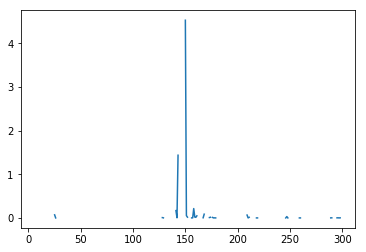

In [123]:
densReduced['density_std'].plot()

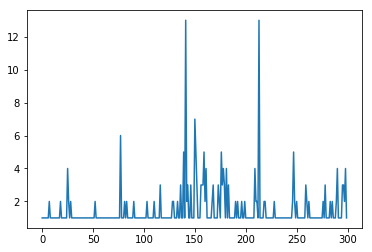

In [125]:
densReduced['numSamp'].plot()

In [171]:
cnt=0

for x in densityData['comp']:
    print(x)
    cnt+=1
    if cnt==30:
        break

Ce1 Al9
Al3 Fe1 B1
Zr1 Al17 Ni2
Zr5 Al82 Ni13
Hf1 Al17 Ni2
Nb1 Al17 Ni2
Y10 Al87 Ni3
Y2 Al17 Ni1
La3 Al42 Ni5
La5 Al86 Ni9
La1 Al17 Ni2
Ce1 Al17 Ni2
Ce3 Al42 Ni5
Ce5.33 Al84 Ni10.67
Gd6 Al87 Ni7
Pr1 Al17 Ni2
Nd1 Al17 Ni2
Y6 Sc0.5 Al86 Co2.94 Si0.5 Ni4.06
La1.5 Y4.5 Al86 Co1 Ni7
Ce1 Al18 Fe1
Gd4.3 Al87 Fe8.7
Mg152 Al1425 Cu323 Ni1
Y2 Al17 Ni1
Ce2 Al88 Fe1 Ni9
Al47 V2 Fe1
Ti5 Al93 Fe2
Y2 Mg13 Cu5
Y2 Mg13 Cu5
Y2 Mg13 Cu3 Ag2
Y2 Mg13 Cu3 Ag2
